### Importing Python Libraries

In [523]:
#Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

### Reading datasets and analysing for missing values

In [525]:
#read file
df = pd.read_csv("day.csv", header=0)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Check Shape

In [527]:
df.shape

(730, 16)

### Data Cleaning Process

#### 1- Checking Null Values

In [529]:
df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### None of the columm has null values

<h3> Remove Columns </h3>
<p> Removing Casual and Registered Columns as  CNT column is addition of  'Casual' and 'Registered' Columns.</p>

In [531]:
df.drop(['casual', 'registered'], axis=1, inplace=True)

<p>dteday Column not required as we already have Year and Month Column</p>

In [533]:
df.drop(['dteday'], axis=1, inplace=True)

temp and atemp are highly co-related . so would drop atemp column

In [535]:
temp_atemp_corr = df['temp'].corr(df['atemp'])
temp_atemp_corr

0.991696178690565

In [537]:
df.drop(['atemp'], axis=1, inplace=True)

<p>Removing <b>instant</b> column  as it is serial nunber </p>

In [539]:
df.drop(['instant'], axis=1, inplace=True)

As working day 0 indicates holiday , dropping <b>holiday</b> Column


In [541]:
df.drop(['holiday'], axis=1, inplace=True)

df.head(5)

### Data Type Analysis & Conversion

In [546]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   weekday     730 non-null    int64  
 4   workingday  730 non-null    int64  
 5   weathersit  730 non-null    int64  
 6   temp        730 non-null    float64
 7   hum         730 non-null    float64
 8   windspeed   730 non-null    float64
 9   cnt         730 non-null    int64  
dtypes: float64(3), int64(7)
memory usage: 57.2 KB


### EDA - Visualization

<b> Visualization for Numerical Columns </b>

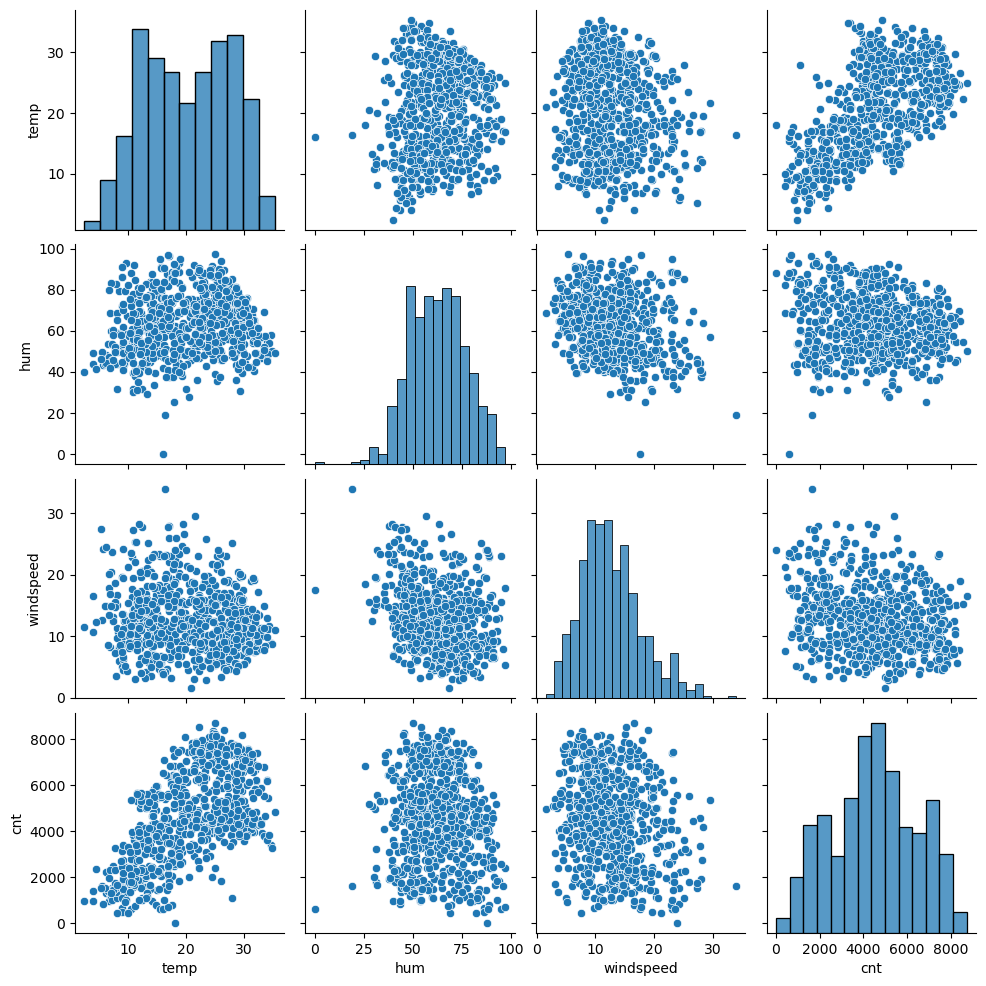

In [548]:
#Choosing Numerical Columns
import seaborn as sns
sns.pairplot(df, vars=['temp','hum','windspeed','cnt'])
plt.show()

<b>Visualization for Categorical Columns </b>

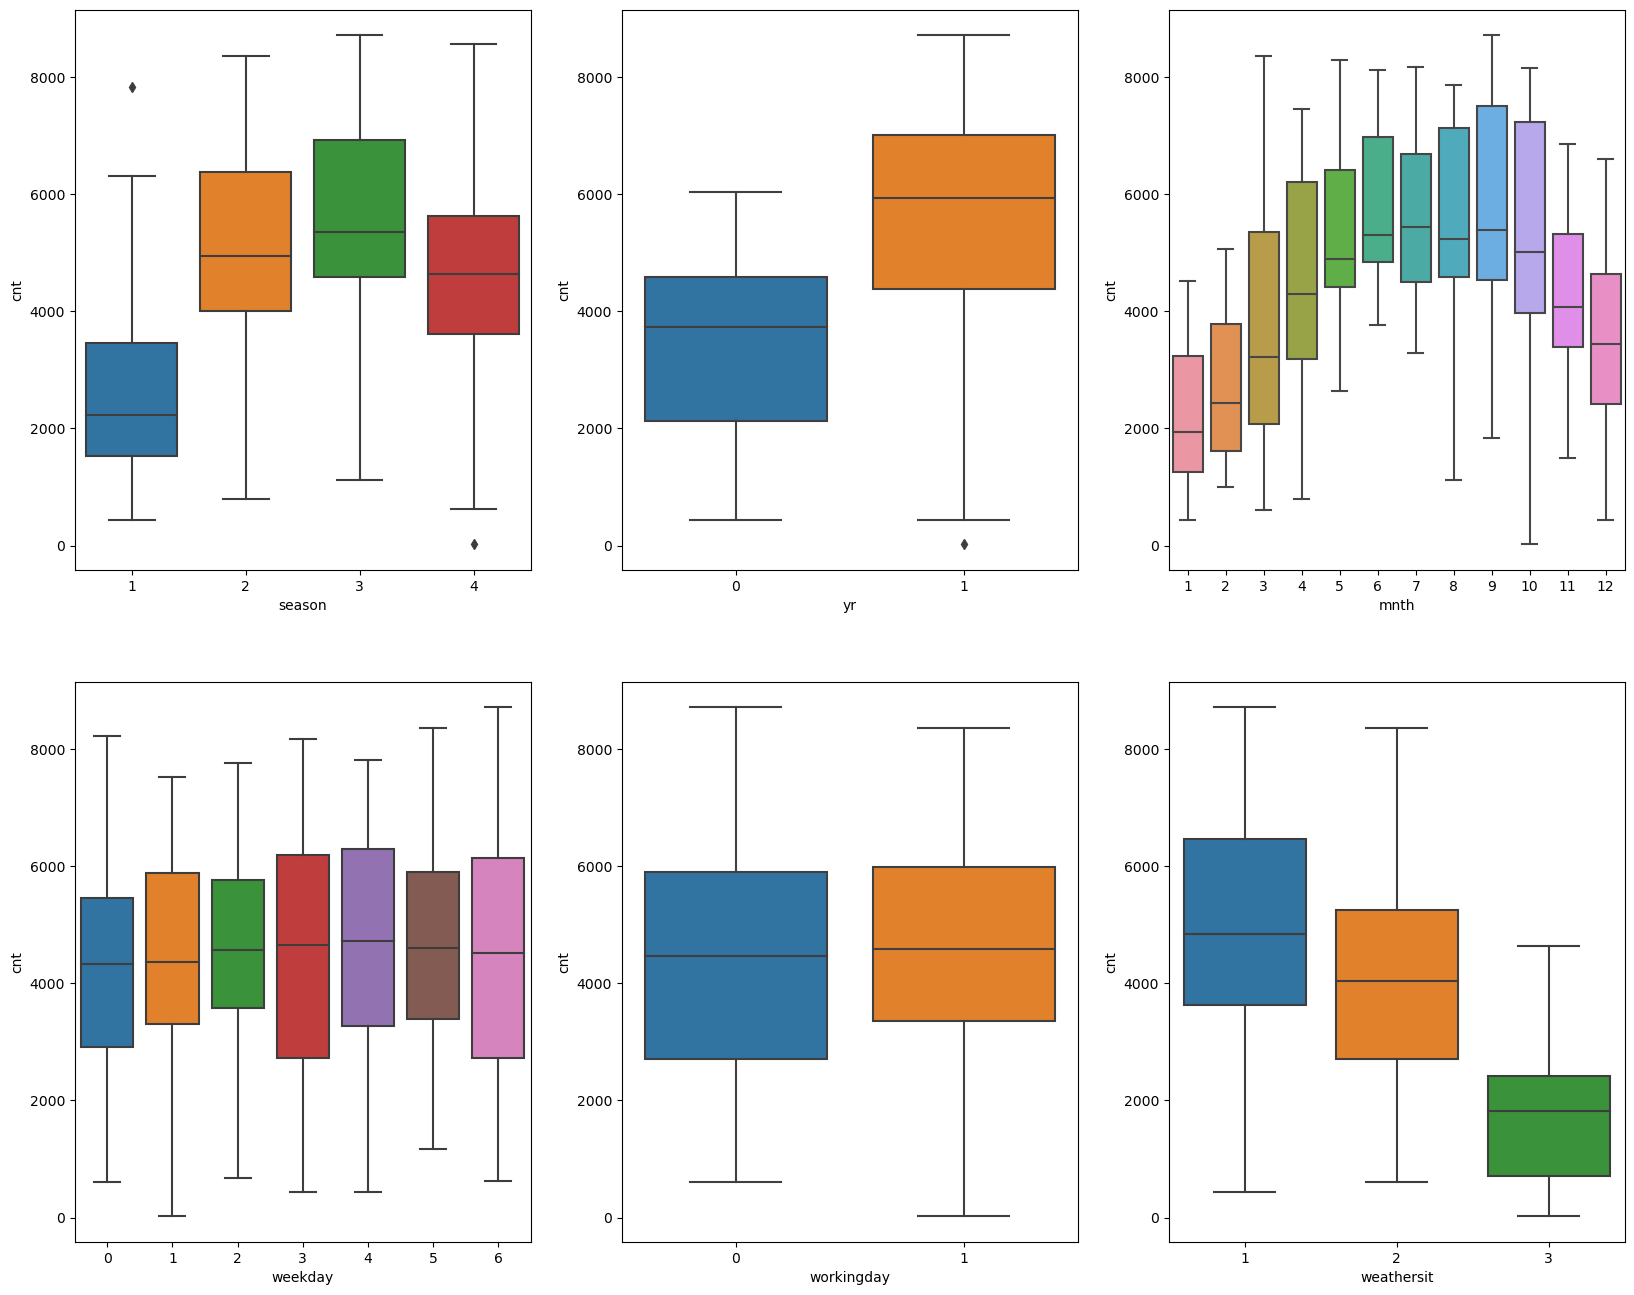

In [549]:
#visualization for categorical attributes
plt.figure(figsize=(20,16))
plt.subplot(2,3,1)
sns.boxplot(x="season", y="cnt", data=df)

plt.subplot(2,3,2)
sns.boxplot(x="yr", y="cnt", data=df)

plt.subplot(2,3,3)
sns.boxplot(x="mnth", y="cnt", data=df)

plt.subplot(2,3,4)
sns.boxplot(x="weekday", y="cnt", data=df)

plt.subplot(2,3,5)
sns.boxplot(x="workingday", y="cnt", data=df)

plt.subplot(2,3,6)
sns.boxplot(x="weathersit", y="cnt", data=df)

plt.show()

<h4> Observations from BoxPlot</h4>
<ol>
    <li> Demand for Bikes is highest in the Month of Sep (09) and Oct(10). Jan(1) and Feb(2) are having lowest demand</li>
    <li> Demand for Bikes is highest in the Fall(3) and lowest in Spring(1)</li>
    <li> As BoomBikes started thier setup in 2018 and there is a considerable increased demand in 2019(0) as compare to 2018(1)</li>
    <li> BoomBikes demands shows a increased pattern in weather situation such as Clear, Few clouds, Partly cloudy, Partly cloudy (1)</li>
    <li> BoomBikes demands is quite similar in working and weekends</li>
</ol>

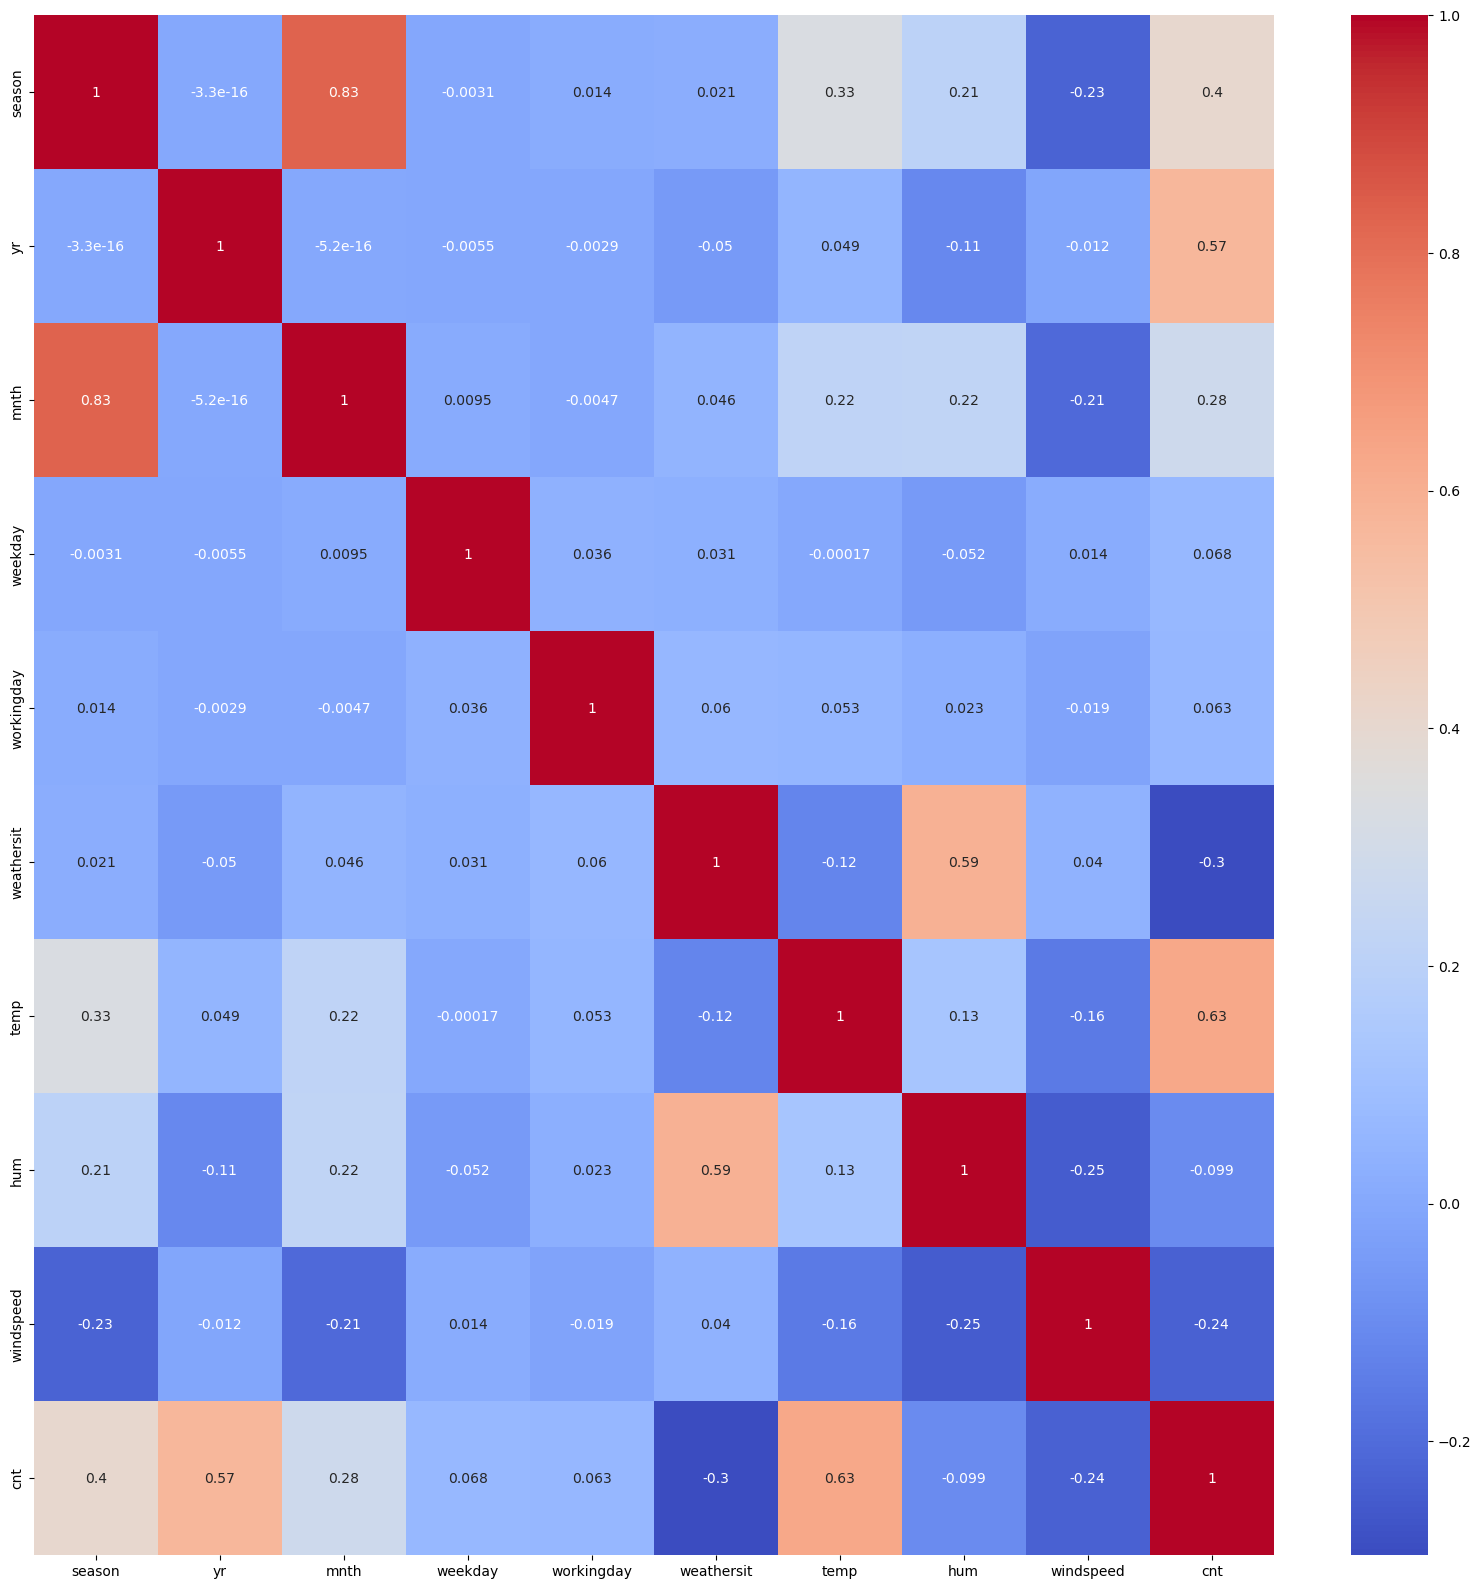

In [552]:
plt.figure(figsize = (20,20))
sns.heatmap(df.corr() , annot=True , cmap = 'coolwarm')
plt.show()

<h3>Model building Steps</h3>
<p>Encoding:</p>
<ol>
<li>Check is Binary categorical column is having values as 0 and 1 only</li>
<li>Creating Dummy Variables where categorical columns having unique values greater than 2</li>
</ol>

<p><b>Binary Value Columns</b></br>
<b>WorkingDay</b> is only Binary Column and both having values as '0' and '1' only.

<p><h4>Categorical Columns having Unique values greater than 2 </h4> </p>
<p><b>Month</b>,<b>Season</b>,<b>weekday</b> and <b>WeatherSit</b> Columns needs to be encoded.</p>
<p><b>Year</b> column also need to have values as 2018 and 2019 instead of 0 and 1 for dummy column creation.</p>

In [554]:
# Adding actual Value of Season Column
df['season'] = df['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,1,6,0,2,14.110847,80.5833,10.749882,985
1,Spring,0,1,0,0,2,14.902598,69.6087,16.652113,801
2,Spring,0,1,1,1,1,8.050924,43.7273,16.636703,1349
3,Spring,0,1,2,1,1,8.200000,59.0435,10.739832,1562
4,Spring,0,1,3,1,1,9.305237,43.6957,12.522300,1600


In [556]:
# Adding actual Value of Month Column
df.mnth = df.mnth.map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr' , 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'})
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,Jan,6,0,2,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,0,0,2,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,1,1,1,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,2,1,1,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,3,1,1,9.305237,43.6957,12.522300,1600


In [558]:
df.weekday.value_counts()

weekday
6    105
0    105
1    105
2    104
4    104
5    104
3    103
Name: count, dtype: int64

In [560]:
# Adding actual Value of Weathersit Column
df.weekday = df.weekday.map({0:'Tuesday', 1:'Wednesday', 2:'Thursday' , 3:'Friday', 4:'Saturday', 5:'Sunday',6:'Monday',})
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,Jan,Monday,0,2,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,Tuesday,0,2,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,Wednesday,1,1,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,Thursday,1,1,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,Friday,1,1,9.305237,43.6957,12.522300,1600


In [562]:
# Adding actual Value of Weathersit Column
df.weathersit = df.weathersit.map({1:'Clear', 2:'Mist', 3:'Light_Snow', 4:'Heavy_Rain'})
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt
0,Spring,0,Jan,Monday,0,Mist,14.110847,80.5833,10.749882,985
1,Spring,0,Jan,Tuesday,0,Mist,14.902598,69.6087,16.652113,801
2,Spring,0,Jan,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349
3,Spring,0,Jan,Thursday,1,Clear,8.200000,59.0435,10.739832,1562
4,Spring,0,Jan,Friday,1,Clear,9.305237,43.6957,12.522300,1600


<h4>Creating Dummy Variable </br>for Categorical Values which is having unique values greater than 2</h4>

In [564]:
# Creating Dummy for season column
dummy_Season = pd.get_dummies(df['season'], drop_first = True)

In [566]:
# Creating Dummy for Month column
dummy_Month = pd.get_dummies(df['mnth'], drop_first = True)

In [568]:
# Creating Dummy for Weekday column
dummy_Weekday = pd.get_dummies(df['weekday'], drop_first = True)

In [570]:
# Creating Dummy for weathersit column
dummy_WeatherSituation = pd.get_dummies(df['weathersit'], drop_first = True)

<h4> Concatinating Dummy Columns with Original Dataframe</h4>

In [572]:
df = pd.concat([df , dummy_Season] , axis=1)
df = pd.concat([df , dummy_Month] , axis=1)
df = pd.concat([df , dummy_Weekday] , axis=1)
df = pd.concat([df , dummy_WeatherSituation] , axis=1)

In [574]:
df.head()

,season,yr,mnth,weekday,workingday,weathersit,temp,hum,windspeed,cnt,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
0,Spring,0,Jan,Monday,0,Mist,14.110847,80.5833,10.749882,985,...,False,False,True,False,False,False,False,False,False,True
1,Spring,0,Jan,Tuesday,0,Mist,14.902598,69.6087,16.652113,801,...,False,False,False,False,False,False,True,False,False,True
2,Spring,0,Jan,Wednesday,1,Clear,8.050924,43.7273,16.636703,1349,...,False,False,False,False,False,False,False,True,False,False
3,Spring,0,Jan,Thursday,1,Clear,8.200000,59.0435,10.739832,1562,...,False,False,False,False,False,True,False,False,False,False
4,Spring,0,Jan,Friday,1,Clear,9.305237,43.6957,12.522300,1600,...,False,False,False,False,False,False,False,False,False,False


<h4> Dropping Original Columns for which Dummy Columns Created<h4>

In [576]:
df.drop(["season" , "mnth" , "weekday" , "weathersit"], inplace=True, axis=1)

In [469]:
df.head()

,yr,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,2,3
0,0,0,14.110847,80.5833,10.749882,985,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
1,0,0,14.902598,69.6087,16.652113,801,True,False,False,False,...,False,False,False,False,False,False,True,False,True,False
2,0,1,8.050924,43.7273,16.636703,1349,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,0,1,8.200000,59.0435,10.739832,1562,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
4,0,1,9.305237,43.6957,12.522300,1600,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [578]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 28 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   yr          730 non-null    int64  
 1   workingday  730 non-null    int64  
 2   temp        730 non-null    float64
 3   hum         730 non-null    float64
 4   windspeed   730 non-null    float64
 5   cnt         730 non-null    int64  
 6   Spring      730 non-null    bool   
 7   Summer      730 non-null    bool   
 8   Winter      730 non-null    bool   
 9   Aug         730 non-null    bool   
 10  Dec         730 non-null    bool   
 11  Feb         730 non-null    bool   
 12  Jan         730 non-null    bool   
 13  Jul         730 non-null    bool   
 14  Jun         730 non-null    bool   
 15  Mar         730 non-null    bool   
 16  May         730 non-null    bool   
 17  Nov         730 non-null    bool   
 18  Oct         730 non-null    bool   
 19  Sep         730 non-null    b

In [580]:
df.Feb.value_counts()

Feb
False    674
True      56
Name: count, dtype: int64

<h3>Model Training Steps</h3>

<b>1- Splitting Dataset into Training and Test Data</b>

In [582]:
#Split Data into Train and Test
df_train, df_test = train_test_split(df, train_size=0.8, random_state=100)

In [584]:
df_train.head()

,yr,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
367,1,1,6.150000,44.1250,24.499957,2236,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
648,1,1,17.835000,46.3333,12.166932,7570,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
44,0,1,17.015000,37.5833,27.999836,1913,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
705,1,1,13.154153,76.4167,8.750200,5008,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
379,1,0,6.833347,41.9167,16.834286,2311,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [586]:
df_test.head()

,yr,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
184,0,0,29.793347,63.7917,5.459106,6043,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
535,1,1,32.082500,59.2083,7.625404,6211,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
299,0,1,19.270000,81.2917,13.250121,2659,False,False,True,False,...,True,False,False,True,False,False,False,False,False,True
221,0,1,31.433347,42.4167,13.417286,4780,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
152,0,1,29.315000,30.5000,19.583229,4968,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


<b>2-Applying Scaling on Training Data Set</b>

In [588]:
#Scaling data using MinMax Approach
scaler = MinMaxScaler()
num_var = ['temp', 'hum', 'windspeed', 'cnt']
df_train[num_var] = scaler.fit_transform(df_train[num_var])
df_train.head()

,yr,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
367,1,1,0.113228,0.454701,0.695175,0.254717,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
648,1,1,0.468352,0.477458,0.299450,0.868385,False,False,True,False,...,True,False,False,True,False,False,False,False,False,False
44,0,1,0.443431,0.387290,0.807474,0.217556,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
705,1,1,0.326094,0.787463,0.189819,0.573631,False,False,True,False,...,False,False,False,False,True,False,False,False,False,True
379,1,0,0.133996,0.431945,0.449210,0.263346,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [590]:
df_train.describe()

,yr,workingday,temp,hum,windspeed,cnt
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.513699,0.667808,0.537414,0.649499,0.319463,0.515792
std,0.500241,0.471403,0.225336,0.144219,0.168114,0.225336
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.340113,0.535852,0.199177,0.350696
50%,1.000000,1.000000,0.545191,0.653714,0.294764,0.522837
75%,1.000000,1.000000,0.736512,0.752361,0.410413,0.691872
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<b>Splitting Training Dataset into X_Train and Y_Train Data</b>

In [592]:
#Let's create X and y train sets

#cut price column and assign to X_train
y_train = df_train.pop('cnt') 
X_train = df_train

In [594]:
X_train.head()

,yr,workingday,temp,hum,windspeed,Spring,Summer,Winter,Aug,Dec,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
367,1,1,0.113228,0.454701,0.695175,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
648,1,1,0.468352,0.477458,0.299450,False,False,True,False,False,...,True,False,False,True,False,False,False,False,False,False
44,0,1,0.443431,0.387290,0.807474,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
705,1,1,0.326094,0.787463,0.189819,False,False,True,False,True,...,False,False,False,False,True,False,False,False,False,True
379,1,0,0.133996,0.431945,0.449210,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [596]:
y_train.head()

367    0.254717
648    0.868385
44     0.217556
705    0.573631
379    0.263346
Name: cnt, dtype: float64

<b>3-Building Model</b>

#### Using LinearRegression Function from Scikit

In [598]:
#importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [602]:
lm = LinearRegression()
lm.fit(X_train, y_train)
rfe = RFE(lm, n_features_to_select=15)
rfe = rfe.fit(X_train, y_train)

In [604]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))
#rfe.support_ shows whether feature is important or not, rfe.ranking_ shows significance - 1 is highest

[('yr', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('Spring', True, 1),
 ('Summer', False, 3),
 ('Winter', True, 1),
 ('Aug', False, 8),
 ('Dec', True, 1),
 ('Feb', False, 4),
 ('Jan', True, 1),
 ('Jul', True, 1),
 ('Jun', False, 10),
 ('Mar', False, 12),
 ('May', False, 7),
 ('Nov', True, 1),
 ('Oct', False, 9),
 ('Sep', False, 2),
 ('Monday', True, 1),
 ('Saturday', False, 13),
 ('Sunday', False, 11),
 ('Thursday', False, 6),
 ('Tuesday', True, 1),
 ('Wednesday', False, 5),
 ('Light_Snow', True, 1),
 ('Mist', True, 1)]

In [606]:
#Now pick all those columns where rfe.support_ is True
col = X_train.columns[rfe.support_]
col

Index(['yr', 'workingday', 'temp', 'hum', 'windspeed', 'Spring', 'Winter',
       'Dec', 'Jan', 'Jul', 'Nov', 'Monday', 'Tuesday', 'Light_Snow', 'Mist'],
      dtype='object')

<b>Building Model using StatsModel for statistical Analysis</b>

In [608]:
#building a X_train dataset with applicable columns only
X_train_rfe = X_train[col]

In [616]:
import statsmodels.api as sm
#Adding constant
X_train_rfe = sm.add_constant(X_train_rfe)

In [626]:
lm = sm.OLS(y_train, X_train_rfe.astype(float)).fit()



In [628]:
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     216.6
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          2.02e-223
Time:                        16:36:56   Log-Likelihood:                 598.33
No. Observations:                 584   AIC:                            -1165.
Df Residuals:                     568   BIC:                            -1095.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2720      0.038      7.227      0.000       0.198       0.346
yr             0.2289      0.007     30.876      0.000       0.214       0.243
workingday     0.0946      0.023      4.154      0.000       0.050       0.139
temp           0.4458      0.031     14.594      0.000       0.386       0.506
hum           -0.1295      0.035     -3.671      0.000      -0.199      -0.060
windspeed     -0.1838      0.024     -7.763      0.000      -0.230      -0.137
Spring        -0.1105      0.014     -7.800      0.000      -0.138      -0.083
Winter         0.0817      0.012      6.557      0.000       0.057       0.106
Dec           -0.0604      0.015     -3.937      0.000      -0.091      -0.030
Jan           -0.0500      0.016     -3.056      0.002      -0.082      -0.018
Jul           -0.0787      0.016     -5.030      0.000      -0.109      -0.048
Nov           -0.0688      0.017     -4.041      0.000      -0.102      -0.035
Monday         0.1049      0.024      4.332      0.000       0.057       0.152
Tuesday        0.0436      0.024      1.806      0.071      -0.004       0.091
Light_Snow    -0.2634      0.025    -10.534      0.000      -0.313      -0.214
Mist          -0.0597      0.010     -6.135      0.000      -0.079      -0.041
==============================================================================
Omnibus:                       96.561   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              283.184
Skew:                          -0.797   Prob(JB):                     3.22e-62
Kurtosis:                       6.017   Cond. No.                         24.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [632]:
X_train_vif = X_train_rfe.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
3,hum,31.48
2,temp,19.34
1,workingday,16.38
4,windspeed,4.60
12,Tuesday,4.53
11,Monday,4.42
5,Spring,3.20
6,Winter,2.82
14,Mist,2.34
0,yr,2.09


In [634]:
#hum (humidity) is having VIF value as 32.78 which is more than 5 so lets remove it

X_train_new = X_train_rfe.drop('hum', axis=1)

In [636]:
X_train_new.head()

,const,yr,workingday,temp,windspeed,Spring,Winter,Dec,Jan,Jul,Nov,Monday,Tuesday,Light_Snow,Mist
367,1.0,1,1,0.113228,0.695175,True,False,False,True,False,False,False,False,False,False
648,1.0,1,1,0.468352,0.299450,False,True,False,False,False,False,False,False,False,False
44,1.0,0,1,0.443431,0.807474,True,False,False,False,False,False,False,False,False,False
705,1.0,1,1,0.326094,0.189819,False,True,True,False,False,False,False,False,False,True
379,1.0,1,0,0.133996,0.449210,True,False,False,True,False,False,False,True,False,False


In [640]:
#Adding constant
#X_train_new = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_new.astype(float)).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     226.1
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.00e-221
Time:                        16:39:58   Log-Likelihood:                 591.49
No. Observations:                 584   AIC:                            -1153.
Df Residuals:                     569   BIC:                            -1087.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2041      0.033      6.159      0.000       0.139       0.269
yr             0.2327      0.007     31.347      0.000       0.218       0.247
workingday     0.0946      0.023      4.110      0.000       0.049       0.140
temp           0.4178      0.030     13.973      0.000       0.359       0.477
windspeed     -0.1600      0.023     -6.952      0.000      -0.205      -0.115
Spring        -0.1124      0.014     -7.854      0.000      -0.141      -0.084
Winter         0.0751      0.012      6.027      0.000       0.051       0.100
Dec           -0.0660      0.015     -4.278      0.000      -0.096      -0.036
Jan           -0.0544      0.016     -3.299      0.001      -0.087      -0.022
Jul           -0.0715      0.016     -4.561      0.000      -0.102      -0.041
Nov           -0.0690      0.017     -4.006      0.000      -0.103      -0.035
Monday         0.1060      0.024      4.332      0.000       0.058       0.154
Tuesday        0.0418      0.024      1.715      0.087      -0.006       0.090
Light_Snow    -0.3006      0.023    -13.004      0.000      -0.346      -0.255
Mist          -0.0807      0.008    -10.160      0.000      -0.096      -0.065
==============================================================================
Omnibus:                       99.012   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              298.247
Skew:                          -0.808   Prob(JB):                     1.72e-65
Kurtosis:                       6.106   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<b> VIF Evaluation of the Model </b>

In [644]:
X_train_vif = X_train_new.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
1,workingday,13.31
2,temp,12.62
3,windspeed,4.56
10,Monday,3.78
11,Tuesday,3.72
4,Spring,2.93
5,Winter,2.61
0,yr,2.08
7,Jan,1.66
9,Nov,1.66


<b> workingday is having very high value of VIF. Let's remove it</b>

In [618]:
X_train_rfe.head()

,const,yr,workingday,temp,hum,windspeed,Spring,Summer,Winter,Jan,Jul,Sep,Monday,Tuesday,Light_Snow,Mist
576,1.0,1,1,0.815169,0.725633,0.264686,0,0,0,0,1,0,0,0,0,0
426,1.0,1,0,0.442393,0.640189,0.255342,1,0,0,0,0,0,1,0,0,1
728,1.0,1,0,0.245101,0.498067,0.663106,1,0,0,0,0,0,0,1,0,0
482,1.0,1,0,0.395666,0.504508,0.188475,0,1,0,0,0,0,1,0,0,1
111,1.0,0,1,0.345824,0.751824,0.380981,0,1,0,0,0,0,0,0,0,1


In [646]:
#workingday is having VIF as 16.56 which is more than 5 so lets remove it along with humidity

X_train_new = X_train_rfe.drop(['hum','workingday'], axis=1)

In [650]:
#Adding constant
#X_train_new = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_new.astype(float)).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     235.6
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          2.55e-219
Time:                        16:40:40   Log-Likelihood:                 582.94
No. Observations:                 584   AIC:                            -1138.
Df Residuals:                     570   BIC:                            -1077.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2994      0.024     12.463      0.000       0.252       0.347
yr             0.2323      0.008     30.875      0.000       0.218       0.247
temp           0.4140      0.030     13.661      0.000       0.354       0.473
windspeed     -0.1619      0.023     -6.940      0.000      -0.208      -0.116
Spring        -0.1160      0.014     -8.004      0.000      -0.144      -0.088
Winter         0.0752      0.013      5.953      0.000       0.050       0.100
Dec           -0.0690      0.016     -4.413      0.000      -0.100      -0.038
Jan           -0.0571      0.017     -3.420      0.001      -0.090      -0.024
Jul           -0.0718      0.016     -4.518      0.000      -0.103      -0.041
Nov           -0.0771      0.017     -4.447      0.000      -0.111      -0.043
Monday         0.0152      0.011      1.425      0.155      -0.006       0.036
Tuesday       -0.0488      0.011     -4.624      0.000      -0.070      -0.028
Light_Snow    -0.2975      0.023    -12.699      0.000      -0.343      -0.251
Mist          -0.0796      0.008     -9.885      0.000      -0.095      -0.064
==============================================================================
Omnibus:                      110.316   Durbin-Watson:                   1.945
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              338.683
Skew:                          -0.893   Prob(JB):                     2.86e-74
Kurtosis:                       6.275   Cond. No.                         15.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [654]:
X_train_vif = X_train_new.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
1,temp,4.51
2,windspeed,4.14
3,Spring,2.37
4,Winter,2.37
0,yr,2.07
8,Nov,1.65
6,Jan,1.61
12,Mist,1.52
5,Dec,1.41
7,Jul,1.32


</b>Humidity (hum) is having very high value of VIF. Let's remove it</b>

In [656]:
#Monday is having p-value as 0.165 which is more than 0.05 so lets remove it along with humidity and workingday

X_train_new = X_train_rfe.drop(['hum','workingday','Monday'], axis=1)

In [660]:
#Adding constant
#X_train_new = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_new.astype(float)).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     254.6
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          4.30e-220
Time:                        16:41:25   Log-Likelihood:                 581.91
No. Observations:                 584   AIC:                            -1138.
Df Residuals:                     571   BIC:                            -1081.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3022      0.024     12.617      0.000       0.255       0.349
yr             0.2319      0.008     30.815      0.000       0.217       0.247
temp           0.4132      0.030     13.627      0.000       0.354       0.473
windspeed     -0.1604      0.023     -6.876      0.000      -0.206      -0.115
Spring        -0.1162      0.014     -8.012      0.000      -0.145      -0.088
Winter         0.0753      0.013      5.957      0.000       0.050       0.100
Dec           -0.0687      0.016     -4.394      0.000      -0.099      -0.038
Jan           -0.0571      0.017     -3.415      0.001      -0.090      -0.024
Jul           -0.0713      0.016     -4.483      0.000      -0.103      -0.040
Nov           -0.0777      0.017     -4.476      0.000      -0.112      -0.044
Tuesday       -0.0515      0.010     -4.957      0.000      -0.072      -0.031
Light_Snow    -0.2975      0.023    -12.687      0.000      -0.344      -0.251
Mist          -0.0797      0.008     -9.889      0.000      -0.096      -0.064
==============================================================================
Omnibus:                      105.865   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              335.809
Skew:                          -0.846   Prob(JB):                     1.20e-73
Kurtosis:                       6.307   Cond. No.                         15.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [662]:
X_train_vif = X_train_new.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
1,temp,4.43
2,windspeed,4.10
3,Spring,2.36
4,Winter,2.36
0,yr,2.07
8,Nov,1.65
6,Jan,1.61
11,Mist,1.52
5,Dec,1.41
7,Jul,1.32


In [664]:
#temp is having VIF as 5.18 which is more than 5 so lets remove it along with humidity, Monday and workingday

X_train_new = X_train_rfe.drop(['hum','workingday','Monday','temp'], axis=1)

In [668]:
#Adding constant
#X_train_new = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_new.astype(float)).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     197.2
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.78e-186
Time:                        16:41:59   Log-Likelihood:                 499.69
No. Observations:                 584   AIC:                            -975.4
Df Residuals:                     572   BIC:                            -922.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5945      0.012     48.423      0.000       0.570       0.619
yr             0.2411      0.009     27.966      0.000       0.224       0.258
windspeed     -0.2083      0.027     -7.852      0.000      -0.260      -0.156
Spring        -0.2383      0.013    -18.177      0.000      -0.264      -0.213
Winter         0.0184      0.014      1.340      0.181      -0.009       0.045
Dec           -0.1310      0.017     -7.615      0.000      -0.165      -0.097
Jan           -0.1234      0.018     -6.714      0.000      -0.160      -0.087
Jul            0.0032      0.017      0.189      0.850      -0.031       0.037
Nov           -0.1362      0.019     -7.044      0.000      -0.174      -0.098
Tuesday       -0.0573      0.012     -4.791      0.000      -0.081      -0.034
Light_Snow    -0.3151      0.027    -11.702      0.000      -0.368      -0.262
Mist          -0.0883      0.009     -9.550      0.000      -0.106      -0.070
==============================================================================
Omnibus:                       95.062   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.239
Skew:                          -0.823   Prob(JB):                     1.25e-54
Kurtosis:                       5.738   Cond. No.                         8.90
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [670]:
X_train_vif = X_train_new.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
1,windspeed,2.63
3,Winter,2.33
2,Spring,2.27
0,yr,1.79
7,Nov,1.63
5,Jan,1.59
10,Mist,1.43
4,Dec,1.40
8,Tuesday,1.15
6,Jul,1.11


In [672]:
#Jul is having p-value as 0.704 which is more than 0.05 so lets remove it along with humidity, Monday, temp and workingday

X_train_new = X_train_rfe.drop(['hum','workingday','Monday','temp','Jul'], axis=1)

In [674]:
#Adding constant
#X_train_new = sm.add_constant(X_train_new)

lm = sm.OLS(y_train, X_train_new.astype(float)).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     217.3
Date:                Sun, 19 Nov 2023   Prob (F-statistic):          1.20e-187
Time:                        16:42:24   Log-Likelihood:                 499.67
No. Observations:                 584   AIC:                            -977.3
Df Residuals:                     573   BIC:                            -929.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5951      0.012     50.603      0.000       0.572       0.618
yr             0.2411      0.009     27.994      0.000       0.224       0.258
windspeed     -0.2086      0.026     -7.895      0.000      -0.261      -0.157
Spring        -0.2387      0.013    -18.552      0.000      -0.264      -0.213
Winter         0.0179      0.013      1.330      0.184      -0.009       0.044
Dec           -0.1310      0.017     -7.622      0.000      -0.165      -0.097
Jan           -0.1234      0.018     -6.720      0.000      -0.160      -0.087
Nov           -0.1362      0.019     -7.050      0.000      -0.174      -0.098
Tuesday       -0.0572      0.012     -4.792      0.000      -0.081      -0.034
Light_Snow    -0.3151      0.027    -11.711      0.000      -0.368      -0.262
Mist          -0.0885      0.009     -9.653      0.000      -0.106      -0.070
==============================================================================
Omnibus:                       95.155   Durbin-Watson:                   1.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              248.642
Skew:                          -0.823   Prob(JB):                     1.02e-54
Kurtosis:                       5.740   Cond. No.                         8.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [676]:
X_train_vif = X_train_new.drop('const', axis=1)

#let's create a dataframe which will have all feature names and their VIF values
vif = pd.DataFrame()
vif['features'] = X_train_vif.columns
vif['VIF'] = [variance_inflation_factor(X_train_vif.values.astype(float), i) for i in range(X_train_vif.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending=False)
vif

,features,VIF
1,windspeed,2.55
3,Winter,2.30
2,Spring,2.22
0,yr,1.76
6,Nov,1.63
5,Jan,1.59
9,Mist,1.43
4,Dec,1.40
7,Tuesday,1.15
8,Light_Snow,1.07


<h3>Let's make Prediction on Training Dataset</h3>

In [678]:
y_train_pred = lm.predict(X_train_new)

<b> Let's calculate Residual</b>

In [680]:
res = y_train - y_train_pred

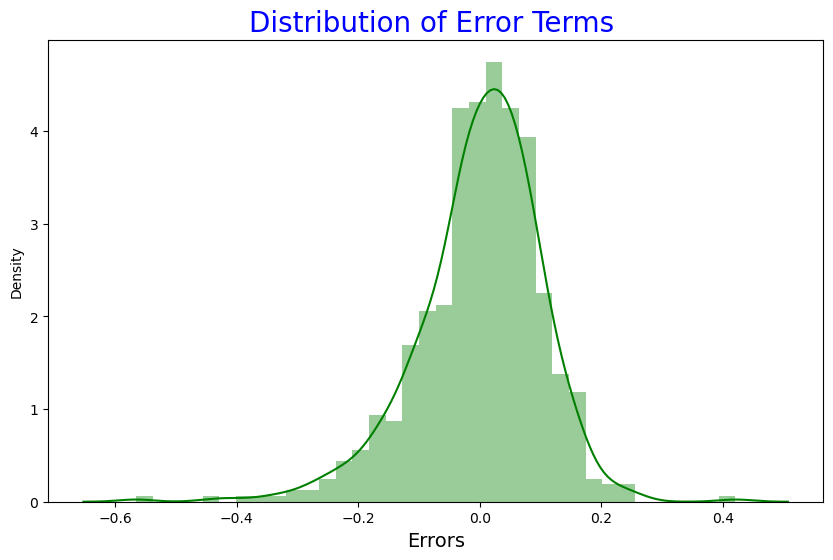

In [690]:
plt.figure(figsize=(10,6))
sns.distplot(res , norm_hist=True,color='green')
plt.xlabel('Errors', fontsize = 14)  
plt.title('Distribution of Error Terms ',fontdict={'fontsize' : 20 , 'color' : "blue" }) 
plt.show()

In [692]:
#Calculating R-Square
r2_score(y_true=y_train, y_pred=y_train_pred)

0.791339330379927

<h3>Prepare Test DataSet for Prediction</h3>

<b>1- Scaling</b>

In [694]:
#Scaling test data numerical columns
df_test[num_var] = scaler.transform(df_test[num_var])
df_test.head()

,yr,workingday,temp,hum,windspeed,cnt,Spring,Summer,Winter,Aug,...,Oct,Sep,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,Light_Snow,Mist
184,0,0,0.831783,0.657364,0.084219,0.692706,False,False,False,False,...,False,False,False,False,False,False,False,True,False,True
535,1,1,0.901354,0.610133,0.153728,0.712034,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
299,0,1,0.511964,0.837699,0.334206,0.303382,False,False,True,False,...,True,False,False,True,False,False,False,False,False,True
221,0,1,0.881625,0.437098,0.339570,0.547400,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
152,0,1,0.817246,0.314298,0.537414,0.569029,False,True,False,False,...,False,False,False,True,False,False,False,False,False,False


In [696]:
df_test.describe()

,yr,workingday,temp,hum,windspeed,cnt
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.445205,0.746575,0.569603,0.635933,0.315127,0.517368
std,0.498699,0.436469,0.238088,0.156357,0.161524,0.212757
min,0.000000,0.000000,0.046591,0.261915,-0.042808,0.055683
25%,0.000000,0.250000,0.359075,0.534457,0.196160,0.391251
50%,0.000000,1.000000,0.560248,0.614856,0.306383,0.508916
75%,1.000000,1.000000,0.801929,0.730570,0.411976,0.649994
max,1.000000,1.000000,0.984424,1.002146,0.800793,0.963300


<b>2-Prepare X_test and y_test datasets</b>

In [698]:
y_test = df_test.pop('cnt')
X_test = df_test

In [700]:
X_test_new = X_test[col]

In [702]:
#Let's drop all columns which we drop during Model Feature Selection Process
X_test_new = X_test_new.drop(['hum','workingday','Monday','temp','Jul'], axis=1)

In [704]:
#Add Constant
X_test_new = sm.add_constant(X_test_new)

In [706]:
X_test_new.head()

,const,yr,windspeed,Spring,Winter,Dec,Jan,Nov,Tuesday,Light_Snow,Mist
184,1.0,0,0.084219,False,False,False,False,False,False,False,True
535,1.0,1,0.153728,False,False,False,False,False,False,False,False
299,1.0,0,0.334206,False,True,False,False,False,False,False,True
221,1.0,0,0.339570,False,False,False,False,False,False,False,False
152,1.0,0,0.537414,False,False,False,False,False,False,False,False


In [708]:
#predicting Y for test dataset
y_test_pred = lm.predict(X_test_new)

In [710]:
#Calculating R-Square
r2_score(y_true=y_test, y_pred=y_test_pred)

0.736026480342383

<h3> R2 (R-Square Values) </h3>
<h4 color="blue"> R2 for Training Dataset is 79.1</h4>
<h4 color="blue"> R2 for Test Dataset is 73.6</h4>

<h2>Correlation Conclusion</h2>
<ol>
<li> Count has high impact from year column as data shows growth from 2018 to 2019</li>
<li> Shared Bike Demand rises considerably in the month of September Month (+Ve Correlation)</li>
<li> Windspeed, Spring, Summer, Winter, Jan, Tuesday, Light-Snow & Mist shows -Ve Correlation. As the values of these variables increases,the demand decreases</li>
</ol>